In [4]:
#Load the common functions and imports
%run functions.py

In [3]:
def OSC_waveform_download(scope, channel, get_data_only = False):
    
    if channel > 4 or channel < 1:
        print("Channel not in range!")
        return 
    
    identification = scope.query('*IDN?')
    identification = identification.split(',')
    scopeType = identification[1]

    if scopeType[:4] != 'DSO6':
        print("Unsupported scope type used, the supported ones are the DSO6000 type from Keysight")
        return
    
    if not get_data_only:
        scope.write(':WAVeform:SOURce CHANnel%d' % (channel))
        scope.write(':WAVeform:UNSigned %d' % (1))
        scope.write(':WAVeform:BYTeorder %s' % ('LSBFirst'))
        scope.write(':WAVeform:FORMat %s' % ('ASCii'))
        scope.write(':ACQuire:COMPlete %d' % (100))
        scope.write(':DIGitize CHANNEL%d' % (channel))

        #Waiting for triggering
        print("Waiting for trigger")
        trigger = [0.0]
        tic = perf_counter()
        try:
            trigger = scope.query_ascii_values(':TER?')
        except:
            print('.', end='')
            sleep(1)
        while(not trigger[0]):
            try:
                trigger = scope.query_ascii_values(':TER?')
                trigger[0]=1 #possible issue, just for test
            except:
                print('.', end='')
                sleep(0.5)
                tic = perf_counter()
            if(perf_counter() > tic + 5):
                trigger[0]=1
                print("")
                print("Trigger timeout, assume that it is okay")
        print("")
        print("Trigger detected")
        sleep(0.5)

    preample = scope.query_ascii_values(':WAVeform:PREamble?')
    
    pre_dict = {'format': int(preample[0]), 
                'type' : int(preample[1]),
                'points' : int(preample[2]),
                'count' : int(preample[3]),
                'xincrement' : preample[4],
                'xorigin' : preample[5],
                'xreference' : int(preample[6]),
                'yincrement' : preample[7],
                'yorigin' : preample[8],
                'yreference' : int(preample[9])}

    data = scope.query_ascii_values(':WAVeform:DATA?', 's')
    #first data contains issues
    #data[0]=data[0].split()
    #data[0]=data[0][1]
    data[0] = data[1]
    data = [float(i) for i in data]
    
    return data, pre_dict

def OSC_plot_waveform(data, preample, xlabel=None, ylabel=None, printFlag = False, printName=None):
    if not xlabel: xlabel = 'Time[ms]'
    if not ylabel: ylabel = 'Voltage[V]'
    if printFlag and not printName: printName = 'Dataplot'
    
    timedata = np.linspace(preample['xorigin'], preample['xincrement']*preample['points']+preample['xorigin'], num=preample['points'])
    plt.plot(timedata, data)
    plt.grid()
    plt.xlabel("Time[s]")
    plt.ylabel("Voltage[V]")
    plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    if printFlag: 
        plt.savefig("Images/" + printName, bbox_inches='tight', dpi=300)
        with open("CSVs/" + printName + ".csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows([data])
    plt.show()
    return
    
def OSC_set_trigger(scope, channel, level):
    if channel > 4 or channel < 1:
        print("Channel not in range!")
        return 
    
    identification = scope.query('*IDN?')
    identification = identification.split(',')
    scopeType = identification[1]

    if scopeType[:4] != 'DSO6':
        print("Unsupported scope type used, the supported ones are the DSO6000 type from Keysight")
        return
    
    scope.write(':TRIGger:MODE %s' % ('EDGE'))
    scope.write(':TRIGger:EDGE:SOURce CHANnel%d' % (channel))
    scope.write(':TRIGger:EDGE:SLOPe %s' % ('POSitive'))
    scope.write(':TRIGger:EDGE:COUPling %s' % ('DC'))
    scope.write(':TRIGger:EDGE:LEVel %G' % (level))
    scope.write(':TRIGger:SWEep %s' % ('NORMal'))
    return 

def OSC_set_resolution(scope, channel, timeRes, voltRes, timeDelay=0.0, voltOffset=0.0):
    if channel > 4 or channel < 1:
        print("Channel not in range!")
        return 
    
    identification = scope.query('*IDN?')
    identification = identification.split(',')
    scopeType = identification[1]

    if scopeType[:4] != 'DSO6':
        print("Unsupported scope type used, the supported ones are the DSO6000 type from Keysight")
        return
    
    scope.write(':CHANnel%d:RANGe %G' % (channel, voltRes))
    scope.write(':CHANnel%d:OFFSet %G' % (channel, voltOffset))
    scope.write(':TIMebase:MAIN:SCALe %G' % (timeRes))
    scope.write(':TIMebase:MAIN:DELay %G' % (timeDelay))
    return

Program started


Do you want to use the information from program.csv?[y/n] y


Starting with ADC_ESD_16A_13kV
Waiting for trigger
........................
Trigger detected


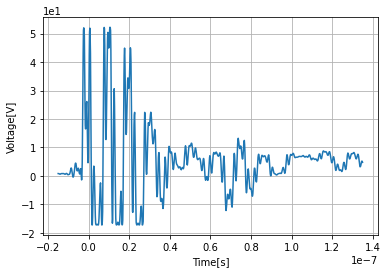

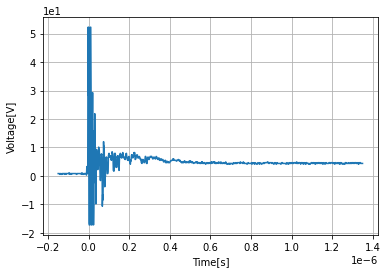

Waiting for trigger

Trigger detected


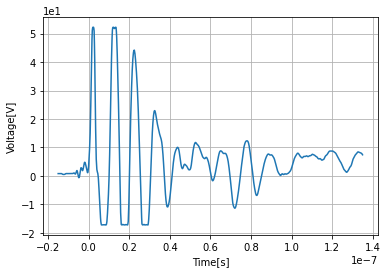

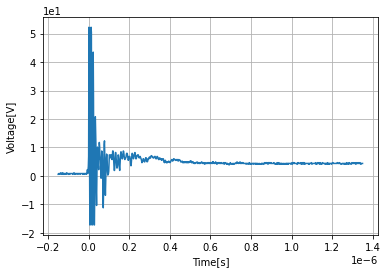

Waiting for trigger
..
Trigger detected


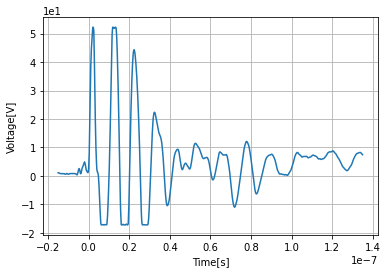

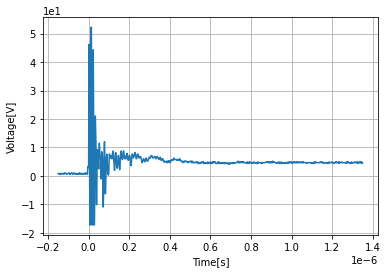

Waiting for trigger
....
Trigger detected


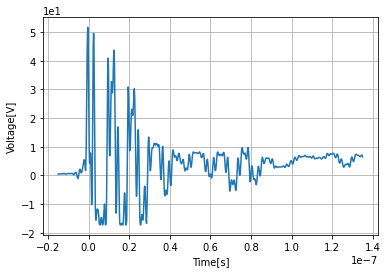

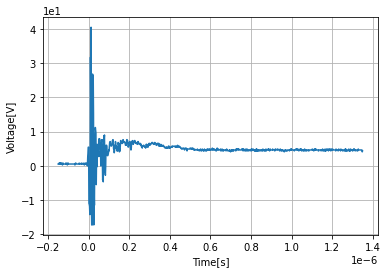

Waiting for trigger

Trigger detected


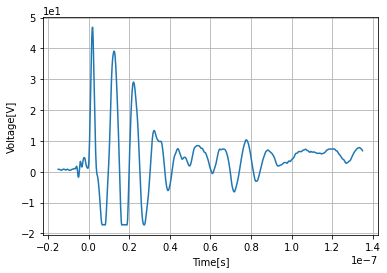

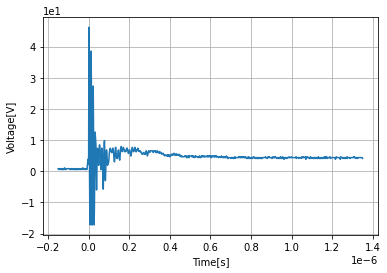

Waiting for trigger

Trigger detected


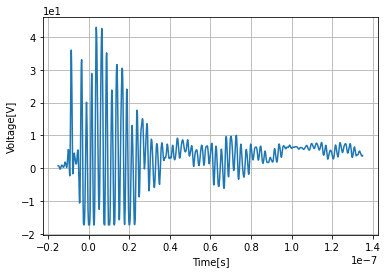

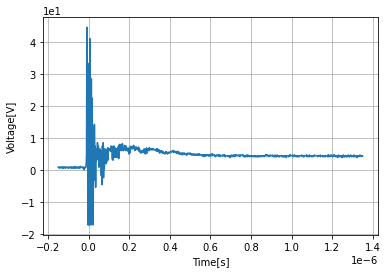

Waiting for trigger

Trigger detected


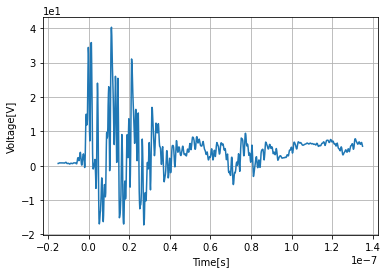

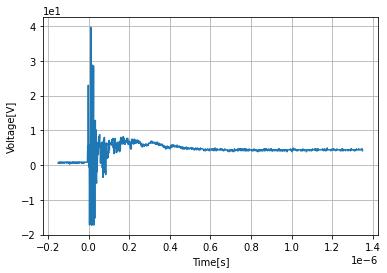

Waiting for trigger

Trigger detected


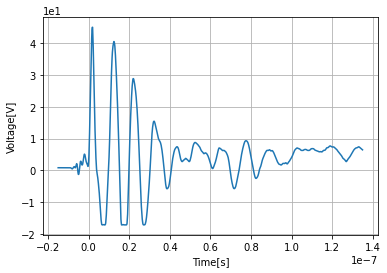

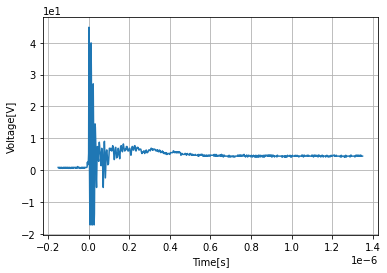

Waiting for trigger

Trigger detected


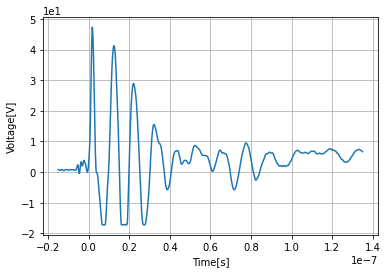

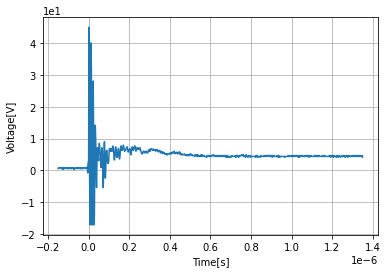

Waiting for trigger

Trigger detected


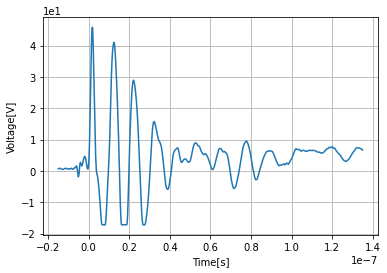

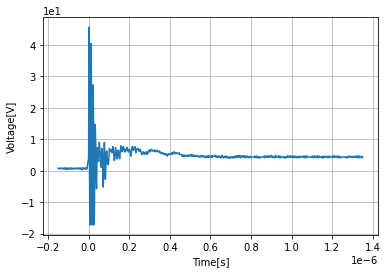

Done with 1 of 2!
Starting with ADC_ESD_16B_13kV
Waiting for trigger
......................
Trigger detected


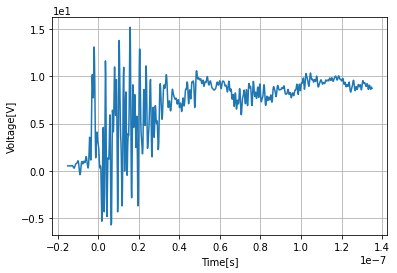

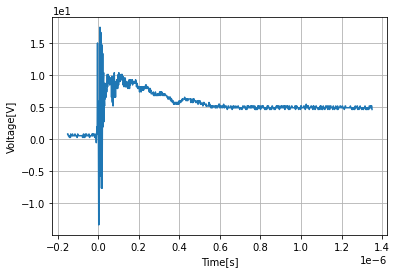

Waiting for trigger

Trigger detected


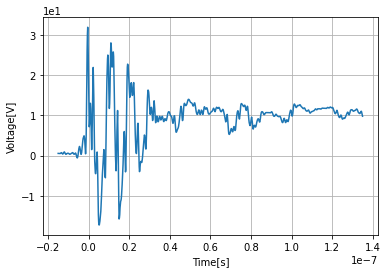

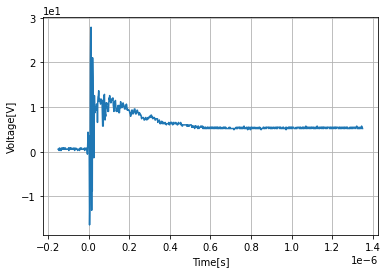

Waiting for trigger

Trigger detected


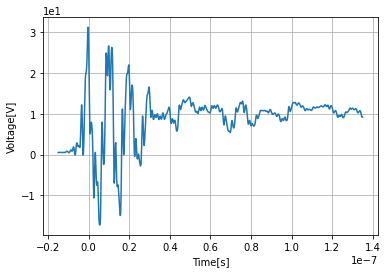

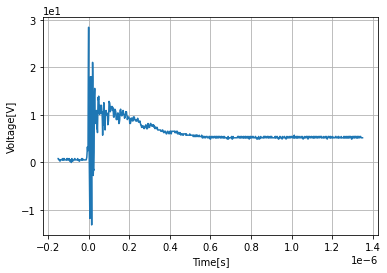

Waiting for trigger

Trigger detected


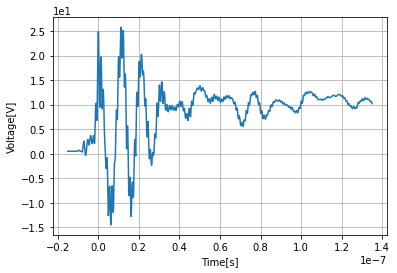

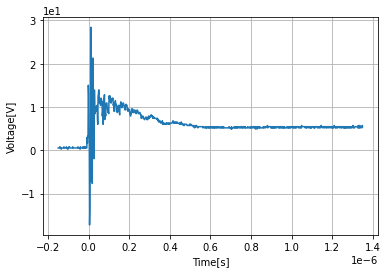

Waiting for trigger

Trigger detected


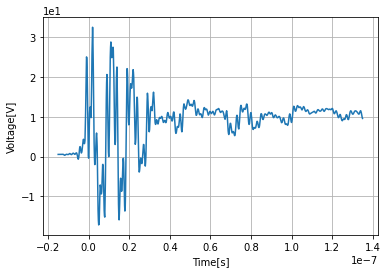

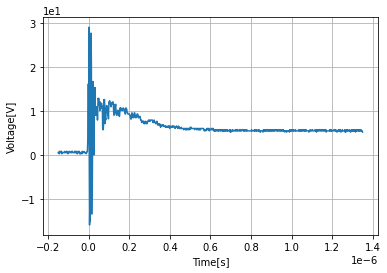

Waiting for trigger
.
Trigger detected


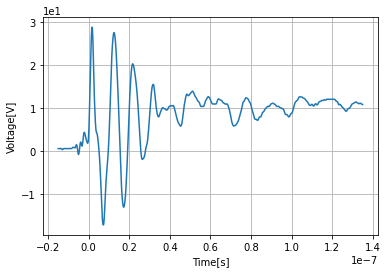

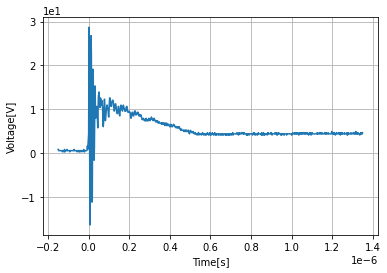

Waiting for trigger

Trigger detected


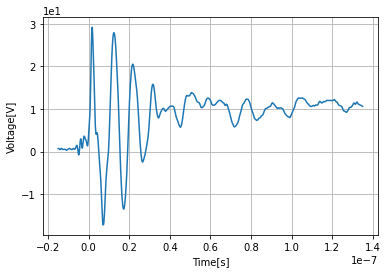

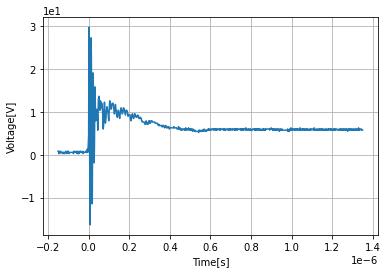

Waiting for trigger

Trigger detected


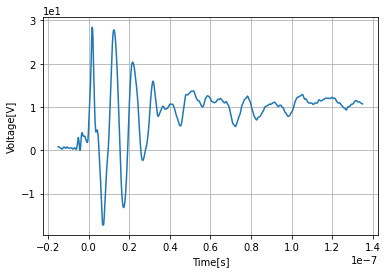

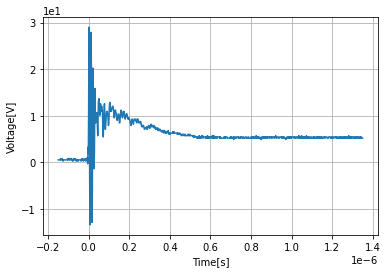

Waiting for trigger

Trigger detected


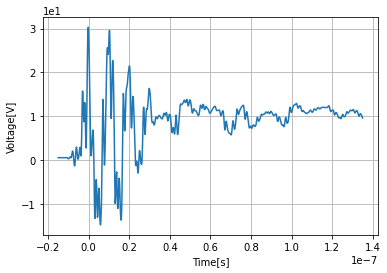

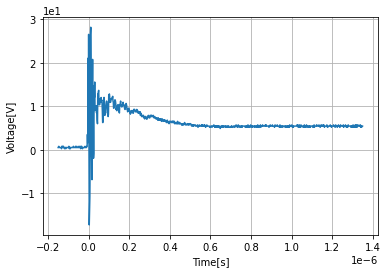

Waiting for trigger

Trigger detected


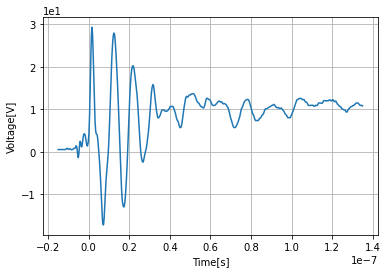

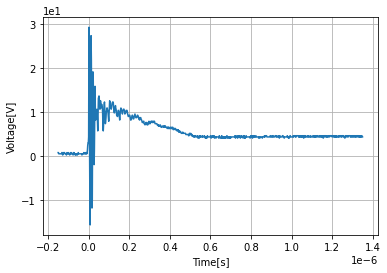

Done with 2 of 2!
Completely done!


In [159]:
# start of Waveform_Download

# Acquires a waveform from channel 1 of an Agilent Infinivision 6000 Series oscilloscope.
# 
# Instructions for Running:
# 1. Setup the oscilloscope with any measurement of interest.
# 2. Enter your instrument address in the Connect step.
# 3. Run the sequence.

print("Program started")

##############################################################################
# VALUES TO CHANGE                                                           #
# If prompt = true, there is no need to input the fields following that line #
# Valid esd_or_surge are: ESD, ESDslow, SURGE                                #
##############################################################################

speak = False

#visa_address = 'USB0::0x0957::0x1724::MY45002452::0::INSTR'
visa_address = 'USB0::0x0957::0x1724::MY45002452::0::INSTR'


prompts = False

probe_channel = 1
trigger_channel = 1 
esd_or_surge = "ESD"
both_quick_and_slow = True

#Test voltage - voltRange (assuming perfect resistors and 2 x headroom (5M and 33k)
#1K -> 16
#2K -> 30
#3K -> 50
#4K -> 65
#5K -> 75
#6K -> 100
#10k-> 200
#Maximum visible voltage on screen
voltRange = 15

howOften = 10

fileName = 'ADC_ESD_6_3k5V'

##############################################################################
if speak: 
    speaker = Dispatch("SAPI.SpVoice").Speak
    speaker("Program started")

if not os.path.exists('CSVs'):
    os.makedirs('CSVs')
if not os.path.exists('Images'):
    os.makedirs('Images')
if not os.path.exists('Dicts'):
    os.makedirs('Dicts')

rm = visa.ResourceManager()
try:
    DSO6034A = rm.open_resource(visa_address)
except:
    print("Visa address: %s invalid, input new address" % (visa_address))
    visa_address = input("New visa address: ")
    DSO6034A = rm.open_resource(visa_address)

#if the device is waiting for old "Digitize" it needs to be stopped before hand
try:
    trigger = DSO6034A.query_ascii_values(':TER?') #Reset the trigger event register
except:
    DSO6034A.clear()
    DSO6034A.close()
    DSO6034A = rm.open_resource(visa_address)

timeGrid = 1.5e-08

if os.path.isfile('program.csv'):
    answ = input("Do you want to use the information from program.csv?[y/n]")
    if answ == 'y' or answ == 'Y':
        prompts = False
        with open("program.csv", "r") as f:
            program = list(csv.DictReader(filter(lambda row: row[0]!='#', f)))#Skip commented lines starting with #
    else: 
        if prompts: pass
        else: program = [{'Filename': fileName, 'ESD or Surge': esd_or_surge, 'Probe Channel': probe_channel, 'Trigger Channel': trigger_channel, 'Volt range': voltRange, 'How often': howOften}]


if prompts: 
    print("%s chosen" % (esd_or_surge))
    probe_channel = input("Probe Channel: ")
    trigger_channel = input("Trigger Channel: ")
    voltRange = input("Volt range: ")
    fileName = input("Filenames: ")
    howOften = input("How often: ")
    program = [{'Filename': fileName, 'ESD or Surge': esd_or_surge, 'Probe Channel': probe_channel, 'Trigger Channel': trigger_channel, 'Volt range': voltRange, 'How often': howOften}]


for i in range(len(program)):            
    
    esd_or_surge = program[i]['ESD or Surge']
    probe_channel = int(program[i]['Probe Channel'])
    trigger_channel = int(program[i]['Trigger Channel'])
    voltRange = int(program[i]['Volt range'])
    fileName = program[i]['Filename']
    howOften = int(program[i]['How often'])
    
    print("Starting with %s" %(fileName))
    if speak: speaker("Starting with %s" %(fileName))
    
    if esd_or_surge == "ESD":
        timeGrid = 1.5e-08
    elif esd_or_surge == "ESDslow":
        timeGrid = 1.5e-07
    elif esd_or_surge == "SURGE":
        timeGrid = 3e-06
    else:
        timeGrid = float(input("ESD/SURGE invalid, input time grid: "))

    voltOffset = voltRange/2*0.5
    timeDelay = 4*timeGrid
    trigger_level = voltRange/10

    #Set channel resolution (scope, channel, time (per grid), voltage range, timedelay (positive:left), voltoffset (positive=down))
    OSC_set_resolution(DSO6034A, probe_channel, timeGrid, voltRange, timeDelay=timeDelay, voltOffset=voltOffset)

    #Set trigger (scope, channel, level)
    OSC_set_trigger(DSO6034A, trigger_channel, trigger_level)

    #Setup files
    fileNames = os.listdir('./CSVs')



    if fileName[-1] != "_": fileName = fileName + "_"

    # Filter file name list for files ending with .csv
    fileNames = [file for file in fileNames if '.csv' and fileName in file]

    fileNums = [file.split('_')[-1] for file in fileNames]
    fileNums = [file.split('.')[0] for file in fileNums]
    fileNums = [int(num) for num in fileNums]

    numOffset = 0

    if fileNums: 
        print("Already %d files with the name %s. New files will be numbered from %d" % (max(fileNums), fileName, max(fileNums)+1))
        numOffset = max(fileNums)+1    
        
    
    
    for j in range(howOften):
        
        if speak: speaker(str(j + numOffset))

        #Get data from single triggered screen (scope, channel)
        data, preample = OSC_waveform_download(DSO6034A, probe_channel)

        #Make image (data, preample, [xlabel], [ylabel], [printFlag], [printName])
        OSC_plot_waveform(data, preample, printName = fileName + str(j + numOffset), printFlag = True)
        
        if both_quick_and_slow:
            #Set channel resolution (scope, channel, time (per grid), voltage range, timedelay (positive:left), voltoffset (positive=down))
            OSC_set_resolution(DSO6034A, probe_channel, timeGrid*10, voltRange, timeDelay=timeDelay*10, voltOffset=voltOffset)
            data, slow_preample = OSC_waveform_download(DSO6034A, probe_channel, get_data_only = True)
            OSC_plot_waveform(data, slow_preample, printName = fileName + "slow_"+ str(j + numOffset)  , printFlag = True)
            OSC_set_resolution(DSO6034A, probe_channel, timeGrid, voltRange, timeDelay=timeDelay, voltOffset=voltOffset)

    save_dictionary(preample, fileName)
    if both_quick_and_slow: save_dictionary(slow_preample, fileName + "slow")
    
    print("Done with %d of %d!" %(i+1, len(program)))
    if speak:  speaker("Done with %d of %d!" %(i+1, len(program)))
    
DSO6034A.close()
rm.close()

print("Completely done!")
if speak: speaker("Yessir, I have finished!")

# end of Waveform_Download


Waiting for trigger
......
Trigger detected


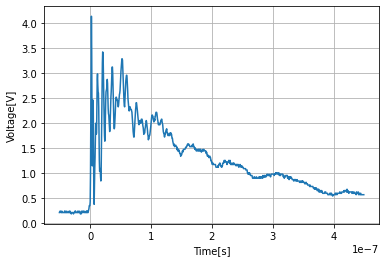

In [136]:
#Get a single data gathering from oscilloscope 
rm = visa.ResourceManager()
DSO6034A = rm.open_resource(visa_address)
temp_filename = "ADC_ESD_6_1k5V_RAD_Connect"
data, preample = OSC_waveform_download(DSO6034A, probe_channel, get_data_only = True)
OSC_plot_waveform(data, preample, printName = temp_filename , printFlag = True)
save_dictionary(preample, temp_filename)
DSO6034A.close()
rm.close()

In [133]:
DSO6034A.close()
rm.close()